## 공통 모듈 import 설정

In [2]:
# 실험 공통 모듈 import 및 유틸 설정
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from cifar_common import (
    device,
    set_seed,
    ensure_dir,
    create_resnet18_cifar,
    create_vit_model,
    evaluate,
)

print("python:", torch.__version__, "| device:", device)
set_seed(42)  # 재현 가능한 비교를 위해 난수 고정


python: 2.3.1+cu121 | device: cuda


## CIFAR-10-C Dataset

In [3]:
class CIFAR10C(Dataset):
    """
    CIFAR-10-C 데이터셋
    - root: CIFAR-10-C 디렉토리
    - corruption: gaussian_noise, fog 등
    - severity: 1~5
    """

    def __init__(self, root, corruption, severity, transform=None):
        assert 1 <= severity <= 5

        data_path = os.path.join(root, f"{corruption}.npy")
        labels_path = os.path.join(root, "labels.npy")

        data = np.load(data_path)
        labels = np.load(labels_path)

        n = 10000
        start, end = (severity - 1) * n, severity * n  # severity마다 1만 장 단위로 슬라이싱

        self.data = data[start:end]
        self.targets = labels[start:end]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = int(self.targets[idx])

        # numpy → PIL 변환 (torchvision transform 사용을 위해)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, label


## CIFAR-10-C DataLoader 래퍼 함수

In [4]:
def create_cifar10c_loader(
    root,
    corruption,
    severity,
    for_vit=False,
    batch_size=128,
):
    # 모델 유형에 맞춰 입력 해상도/정규화를 다르게 적용
    if for_vit:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.4914, 0.4822, 0.4465),
                std=(0.2470, 0.2435, 0.2616),
            ),
        ])

    dataset = CIFAR10C(
        root=root,
        corruption=corruption,
        severity=severity,
        transform=transform,
    )

    # Test 전용 DataLoader이므로 shuffle=False
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )
    return loader


## CIFAR-10-C에서 robustness 평가 함수

In [5]:
def evaluate_on_cifar10c(
    model,
    model_type,
    cifar10c_root,
    corruption_list,
    batch_size=128,
):
    """corruption/세기 조합별로 CIFAR-10-C 정확도를 측정"""
    assert model_type in ["cnn", "vit"]

    for_vit = (model_type == "vit")
    loader_batch = min(batch_size, 64 if for_vit else batch_size)

    criterion = torch.nn.CrossEntropyLoss()

    rows = []

    for corruption in corruption_list:
        for severity in range(1, 6):
            loader = create_cifar10c_loader(
                root=cifar10c_root,
                corruption=corruption,
                severity=severity,
                for_vit=for_vit,
                batch_size=loader_batch,
            )

            test_loss, test_acc = evaluate(model, loader, criterion, device)

            rows.append({
                "model": model_type,
                "corruption": corruption,
                "severity": severity,
                "test_loss": test_loss,
                "test_acc": test_acc,
            })

            print(
                f"[{model_type.upper()}][{corruption}][severity={severity}] "
                f"acc={test_acc:.4f}"
            )

    return pd.DataFrame(rows)


## CIFAR-10-C 경로 및 baseline 설정

In [6]:
# CIFAR-10-C 데이터 위치와 baseline 학습 epoch 지정
CIFAR10C_ROOT = "data/CIFAR-10-C-1"
num_epochs_clean = 20  # baseline에서 모델을 학습한 epoch 수

labels_path = os.path.join(CIFAR10C_ROOT, "labels.npy")
if not os.path.exists(labels_path):
    raise FileNotFoundError(f"{labels_path} 가 존재하지 않습니다. CIFAR-10-C를 먼저 다운로드 해주세요.")


## 전체 실험 실행 (Baseline에서 저장한 모델 불러오기 + robustness 평가)

In [7]:
# baseline에서 학습한 모델 가중치 불러오기
cnn_model = create_resnet18_cifar(num_classes=10)
cnn_model.load_state_dict(
    torch.load("results/baseline/cnn/cnn_epochs_20.pth", map_location=device)
)
cnn_model.to(device)
cnn_model.eval()

vit_model = create_vit_model(
    model_name="vit_tiny_patch16_224",
    num_classes=10,
    pretrained=True,
)
vit_model.load_state_dict(
    torch.load("results/baseline/vit/vit_epochs_20.pth", map_location=device)
)
vit_model.to(device)
vit_model.eval()

# 실험에 사용할 corruption 리스트
corruption_list = [
    "gaussian_noise",
    "shot_noise",
    "motion_blur",
    "brightness",
    "fog",
]

# CIFAR-10-C 전체 평가
df_cnn = evaluate_on_cifar10c(
    model=cnn_model,
    model_type="cnn",
    cifar10c_root=CIFAR10C_ROOT,
    corruption_list=corruption_list,
)

df_vit = evaluate_on_cifar10c(
    model=vit_model,
    model_type="vit",
    cifar10c_root=CIFAR10C_ROOT,
    corruption_list=corruption_list,
)

ensure_dir("results/robustness")

df_robust = pd.concat([df_cnn, df_vit], ignore_index=True)
df_robust.to_csv("results/robustness/robustness_cifar10c_epochs20.csv", index=False)

summary = (
    df_robust.groupby(["model"])["test_acc"]
    .mean()
    .reset_index()
    .rename(columns={"test_acc": "mean_accuracy"})
)

summary.to_csv("results/robustness/robustness_summary.csv", index=False)
summary


[CNN][gaussian_noise][severity=1] acc=0.7747
[CNN][gaussian_noise][severity=2] acc=0.7557
[CNN][gaussian_noise][severity=3] acc=0.7229
[CNN][gaussian_noise][severity=4] acc=0.7053
[CNN][gaussian_noise][severity=5] acc=0.6796
[CNN][shot_noise][severity=1] acc=0.7825
[CNN][shot_noise][severity=2] acc=0.7736
[CNN][shot_noise][severity=3] acc=0.7499
[CNN][shot_noise][severity=4] acc=0.7289
[CNN][shot_noise][severity=5] acc=0.6949
[CNN][motion_blur][severity=1] acc=0.7489
[CNN][motion_blur][severity=2] acc=0.6955
[CNN][motion_blur][severity=3] acc=0.6470
[CNN][motion_blur][severity=4] acc=0.6477
[CNN][motion_blur][severity=5] acc=0.5944
[CNN][brightness][severity=1] acc=0.7832
[CNN][brightness][severity=2] acc=0.7792
[CNN][brightness][severity=3] acc=0.7707
[CNN][brightness][severity=4] acc=0.7566
[CNN][brightness][severity=5] acc=0.7075
[CNN][fog][severity=1] acc=0.7797
[CNN][fog][severity=2] acc=0.7368
[CNN][fog][severity=3] acc=0.6728
[CNN][fog][severity=4] acc=0.5993
[CNN][fog][severity

,model,mean_accuracy
0,cnn,0.709188
1,vit,0.740084


## corruption 평균 기준으로 severity–accuracy 곡선 시각화

/tmp/ipykernel_1448515/3030904407.py:28: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1448515/3030904407.py:28: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.tight_layout()
/home/mini/miniconda3/envs/mini/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mini/miniconda3/envs/mini/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


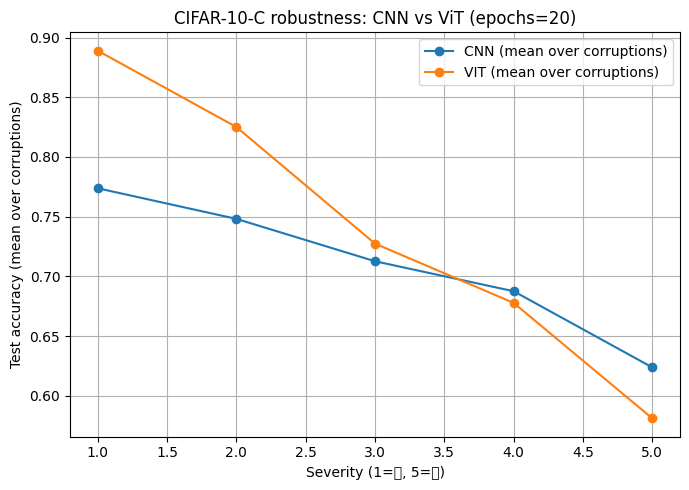

In [8]:
# corruption별 결과를 평균 내고, severity(1~5)에 따른 평균 accuracy를 CNN vs ViT로 비교.

df_mean_severity = (
    df_robust
    .groupby(["model", "severity"])["test_acc"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 5))

for model_name in ["cnn", "vit"]:
    sub = df_mean_severity[df_mean_severity["model"] == model_name]
    if sub.empty:
        continue
    plt.plot(
        sub["severity"],
        sub["test_acc"],
        marker="o",
        label=f"{model_name.upper()} (mean over corruptions)",
    )

plt.xlabel("Severity (1=약, 5=강)")
plt.ylabel("Test accuracy (mean over corruptions)")
plt.title(f"CIFAR-10-C robustness: CNN vs ViT (epochs={num_epochs_clean})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 특정 severity에서 corruption별 bar plot

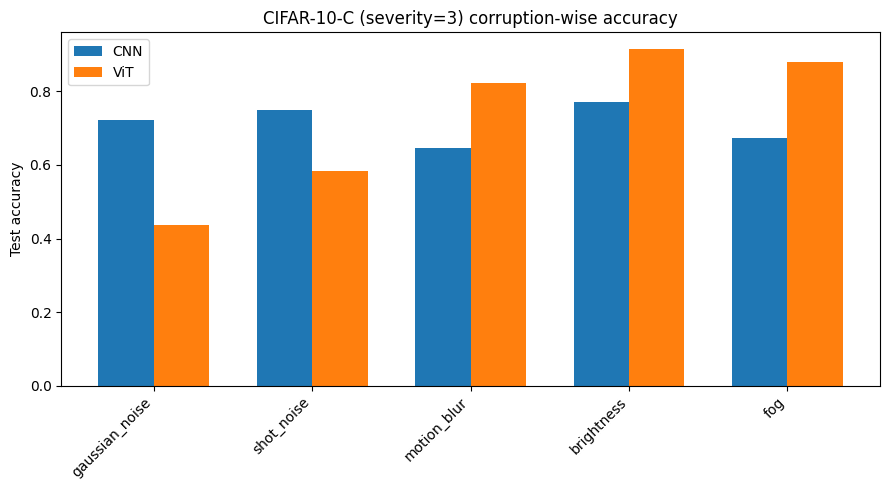

In [9]:
# 변경점: 예를 들어 severity=3(중간 손상)에서
#        각 corruption 타입별로 CNN vs ViT accuracy 차이를 bar plot으로 비교.

target_severity = 3

df_s3 = df_robust[df_robust["severity"] == target_severity]

pivot_s3 = df_s3.pivot_table(
    index="corruption",
    columns="model",
    values="test_acc",
)

pivot_s3 = pivot_s3.reindex(corruption_list)  

pivot_s3

# 위 pivot_s3를 bar plot으로 시각화
plt.figure(figsize=(9, 5))

x = np.arange(len(pivot_s3.index))
width = 0.35

cnn_vals = pivot_s3["cnn"].values
vit_vals = pivot_s3["vit"].values

plt.bar(x - width/2, cnn_vals, width, label="CNN")
plt.bar(x + width/2, vit_vals, width, label="ViT")

plt.xticks(x, pivot_s3.index, rotation=45, ha="right")
plt.ylabel("Test accuracy")
plt.title(f"CIFAR-10-C (severity={target_severity}) corruption-wise accuracy")
plt.legend()
plt.tight_layout()
plt.show()
